In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ahmedkhanak1995/sign-language-gesture-images-dataset")

print("Path to dataset files:", path)

100%|██████████| 191M/191M [00:09<00:00, 21.3MB/s]


Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/ahmedkhanak1995/sign-language-gesture-images-dataset/versions/1


In [2]:
import os
files = os.listdir(path)
print("dataset files: ", files)

dataset files:  ['Gesture Image Pre-Processed Data', 'Gesture Image Data']


In [3]:
import os

# Set dataset root path
dataset_root = path  # Change to actual path

# Dictionary to store dataset structure with full image paths
dataset_dict = {}

# Traverse the dataset folders
for main_folder in ["Gesture Image Data", "Gesture Image Pre-Processed Data"]:
    main_folder_path = os.path.join(dataset_root, main_folder)

    if os.path.isdir(main_folder_path):
        dataset_dict[main_folder] = {}

        for subfolder in os.listdir(main_folder_path):
            subfolder_path = os.path.join(main_folder_path, subfolder)

            if os.path.isdir(subfolder_path):
                # Store full paths instead of just filenames
                dataset_dict[main_folder][subfolder] = [
                    os.path.join(subfolder_path, file)
                    for file in os.listdir(subfolder_path)
                    if file.endswith((".jpg", ".png"))  # Ensure only images are included
                ]

# Print an example entry
for main_cat, sub_cats in dataset_dict.items():
    print(f"\nCategory: {main_cat}")
    for sub_cat, files in sub_cats.items():
        print(f"  Subfolder: {sub_cat} -> {len(files)} images")
        print(f"  Example file path: {files[0]}")
        break  # Just print one example per category


Category: Gesture Image Data
  Subfolder: 6 -> 1500 images
  Example file path: /root/.cache/kagglehub/datasets/ahmedkhanak1995/sign-language-gesture-images-dataset/versions/1/Gesture Image Data/6/513.jpg

Category: Gesture Image Pre-Processed Data
  Subfolder: 6 -> 1500 images
  Example file path: /root/.cache/kagglehub/datasets/ahmedkhanak1995/sign-language-gesture-images-dataset/versions/1/Gesture Image Pre-Processed Data/6/513.jpg


In [4]:
import os
import torch
import random
from sklearn.model_selection import train_test_split
from torchvision import transforms
from PIL import Image
from torch.utils.data import Dataset, DataLoader

# Create a list of (image_path, label)
image_paths = []
labels = []
label_to_index = {}

# Use only half of "Gesture Image Data"
selected_folder = "Gesture Image Data"

if selected_folder in dataset_dict:
    all_labels = set(dataset_dict[selected_folder].keys())  # Unique classes
    label_to_index = {label: idx for idx, label in enumerate(sorted(all_labels))}

    for subfolder, files in dataset_dict[selected_folder].items():
        if len(files) < 2:  # Avoid empty classes
            print(f"Skipping class {subfolder} (not enough images)")
            continue

        random.shuffle(files)  # Shuffle to ensure variety
        half_size = len(files) // 10  # Select 50% of images

        # Store only half of the images
        for file in files[:half_size]:
            image_paths.append(file)
            labels.append(label_to_index[subfolder])

# Ensure we have enough samples before splitting
if len(image_paths) < 2:
    raise ValueError("Not enough images after filtering. Check dataset_dict.")

# Split into train (80%) and test (20%)
train_paths, test_paths, train_labels, test_labels = train_test_split(
    image_paths, labels, test_size=0.2, stratify=labels if len(set(labels)) > 1 else None, random_state=42
)

print(f"Using {len(image_paths)} images total, with {len(train_paths)} for training and {len(test_paths)} for testing.")

Using 5550 images total, with 4440 for training and 1110 for testing.


In [5]:
class ASLDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        image = Image.open(img_path).convert("RGB")  # Ensure RGB format

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.long)

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((64, 64)),  # Resize images to 64x64
    transforms.ToTensor(),         # Convert images to tensors
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize
])

# Create dataset objects
train_dataset = ASLDataset(train_paths, train_labels, transform=transform)
test_dataset = ASLDataset(test_paths, test_labels, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [6]:
import torch.nn as nn
import torch.optim as optim

class ASLCNN(nn.Module):
    def __init__(self, num_classes):
        super(ASLCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)

        self.fc1 = nn.Linear(128 * 8 * 8, 256)  # Flattened size (from pooling)
        self.fc2 = nn.Linear(256, num_classes)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))

        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

# Initialize model
num_classes = len(label_to_index)  # Number of ASL classes
model = ASLCNN(num_classes)

Epoch [1/10], Loss: 1.4437, Accuracy: 57.34%
Epoch [2/10], Loss: 0.2007, Accuracy: 92.68%
Epoch [3/10], Loss: 0.1218, Accuracy: 95.68%
Epoch [4/10], Loss: 0.0729, Accuracy: 97.59%
Epoch [5/10], Loss: 0.0471, Accuracy: 98.40%
Epoch [6/10], Loss: 0.0458, Accuracy: 98.47%
Epoch [7/10], Loss: 0.0415, Accuracy: 98.69%
Epoch [8/10], Loss: 0.0291, Accuracy: 99.01%
Epoch [9/10], Loss: 0.0355, Accuracy: 98.74%
Epoch [10/10], Loss: 0.0209, Accuracy: 99.37%


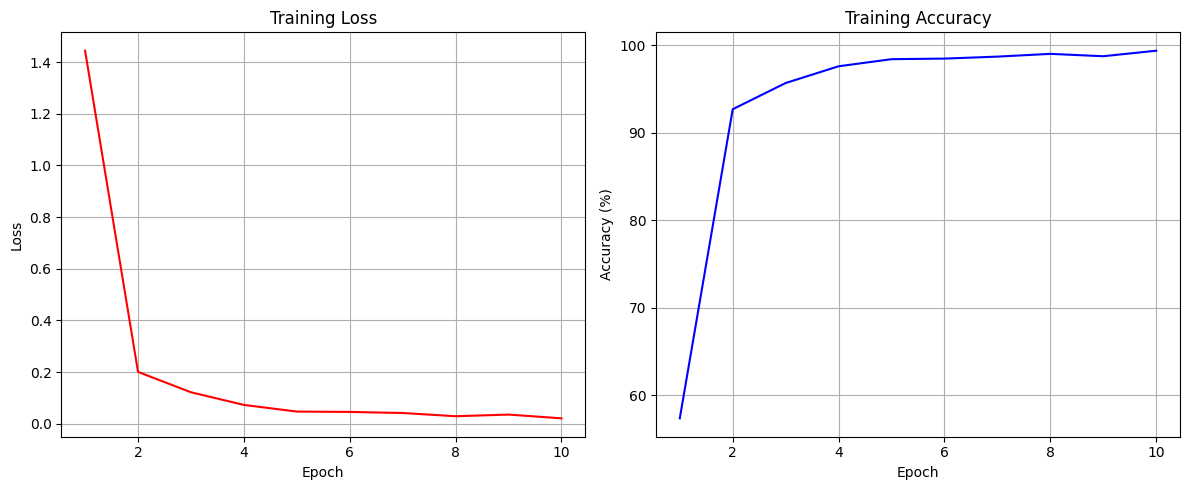

In [7]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# Assuming 'train_loader' and 'model' are defined, and the model is already initialized
# Define loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()  # Assuming multi-class classification
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Lists to store loss and accuracy for each epoch
train_losses = []
train_accuracies = []

num_epochs = 10  # Number of epochs to train

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set model to training mode

    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0

    for images, labels in train_loader:
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Calculate running loss
        running_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

    # Calculate average loss and accuracy for this epoch
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct_predictions / total_predictions * 100

    # Store loss and accuracy for this epoch
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    # Print progress
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%")

# Plotting the loss and accuracy
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True)

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, label='Training Accuracy', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy')
plt.grid(True)

# Show the plots
plt.tight_layout()
plt.show()

In [8]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for images, labels in test_loader:
        #images, labels = images.to(device), labels.to(device)
        outputs = model(images)

        _, predicted = torch.max(outputs, 1)  # Get class index with highest score
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")

Test Accuracy: 99.91%


True class: 7
Predicted class: 7


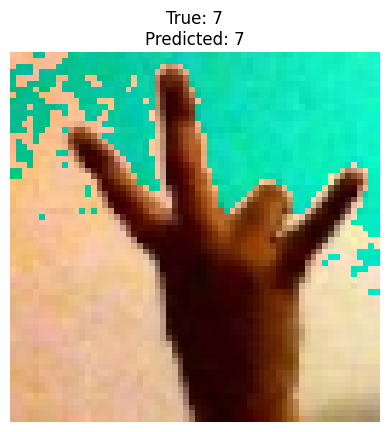

In [20]:
import random
import torch
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image

# Assuming you have the DataLoader 'test_loader' and the trained model 'model'
model.eval()  # Set model to evaluation mode

# 1. Pick a random batch from the test_loader
data_iter = iter(test_loader)  # Create an iterator over the test loader
images, labels = next(data_iter)  # Get the first batch (images and their true labels)

# Pick a random index from the batch
random_index = random.randint(0, len(images) - 1)

# Get the image and its true label
random_image = images[random_index].unsqueeze(0)  # Add batch dimension (batch size = 1)
true_label = labels[random_index].item()

# 2. Pass the random image through the model
with torch.no_grad():  # No gradient calculation during inference
    output = model(random_image)

# 3. Get the predicted class
softmax = torch.nn.Softmax(dim=1)
probabilities = softmax(output)
_, predicted_class = torch.max(probabilities, 1)
predicted_class = predicted_class.item()

# 4. Map the true label and predicted class to the actual label
class_names = list(label_to_index.keys())
true_class_name = class_names[true_label]
predicted_class_name = class_names[predicted_class]

# 5. Output the actual and predicted classes
print(f"True class: {true_class_name}")
print(f"Predicted class: {predicted_class_name}")

# 6. Display the image
# Remove the batch dimension and convert tensor to PIL Image for display
image_to_display = random_image.squeeze(0)  # Remove the batch dimension
image_to_display = transforms.ToPILImage()(image_to_display)  # Convert tensor to PIL Image

# Plotting the image
plt.imshow(image_to_display)
plt.title(f"True: {true_class_name}\nPredicted: {predicted_class_name}")
plt.axis('off')  # Hide axis
plt.show()

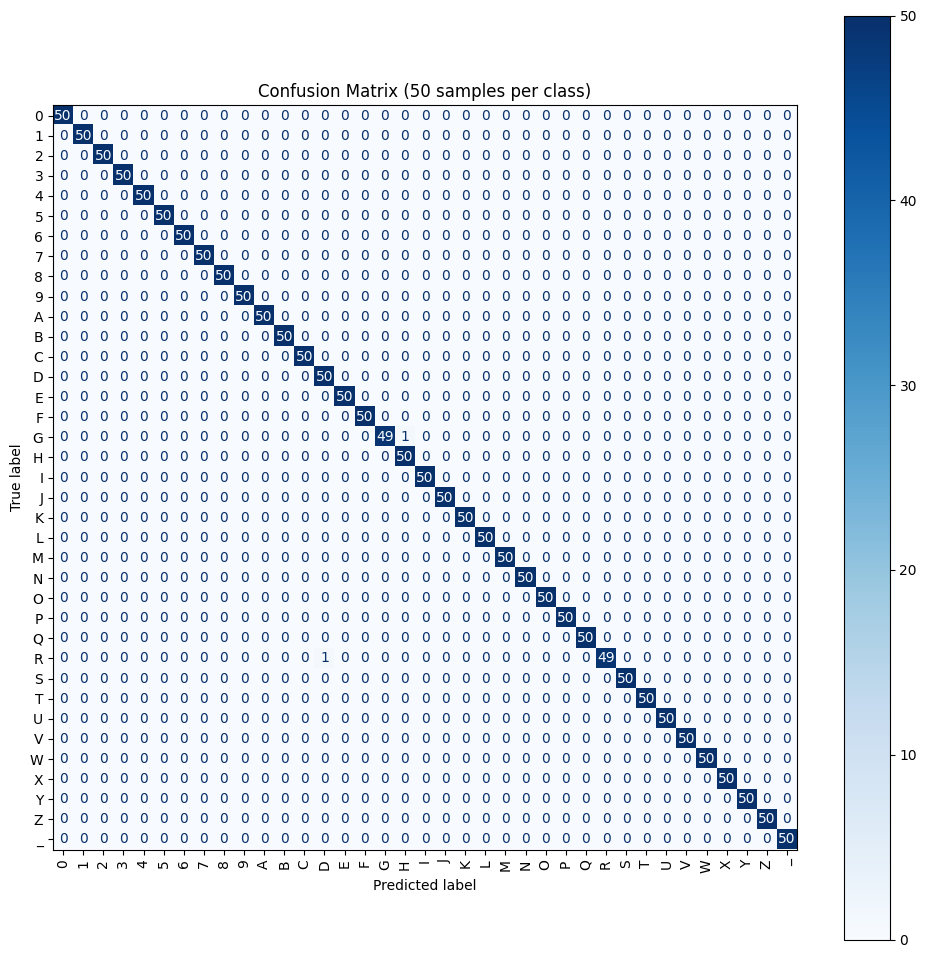


Top misclassifications per class:
- G ➝ misclassified as 'H' (1 times)
- R ➝ misclassified as 'D' (1 times)


In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
from collections import Counter, defaultdict

# Step 1: Sample 50 images per class from the original dataset
sampled_image_paths = []
sampled_labels = []

for class_name, files in dataset_dict["Gesture Image Data"].items():
    if len(files) < 50:
        print(f"Skipping class '{class_name}' - not enough images.")
        continue

    sampled_files = random.sample(files, 50)
    sampled_image_paths.extend(sampled_files)
    sampled_labels.extend([label_to_index[class_name]] * 50)

# Step 2: Create a Dataset and DataLoader for the new test set
sampled_dataset = ASLDataset(sampled_image_paths, sampled_labels, transform=transform)
sampled_loader = DataLoader(sampled_dataset, batch_size=32, shuffle=False)

# Step 3: Run inference on the new test set
all_preds = []
all_trues = []

model.eval()
with torch.no_grad():
    for images, labels in sampled_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.tolist())
        all_trues.extend(labels.tolist())

# Step 4: Confusion matrix
cm = confusion_matrix(all_trues, all_preds)
class_names_sorted = [k for k, v in sorted(label_to_index.items(), key=lambda x: x[1])]

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names_sorted)
fig, ax = plt.subplots(figsize=(12, 12))
disp.plot(ax=ax, cmap='Blues', xticks_rotation=90)
plt.title("Confusion Matrix (50 samples per class)")
plt.grid(False)
plt.show()

# Step 5: Find top misclassifications
misclassifications = defaultdict(Counter)

for true_label, pred_label in zip(all_trues, all_preds):
    if true_label != pred_label:
        true_name = class_names_sorted[true_label]
        pred_name = class_names_sorted[pred_label]
        misclassifications[true_name][pred_name] += 1

# Print most frequent misclassifications per class
print("\nTop misclassifications per class:")
for true_class, errors in misclassifications.items():
    most_common = errors.most_common(1)[0]
    print(f"- {true_class} ➝ misclassified as '{most_common[0]}' ({most_common[1]} times)")


In [23]:
import cv2
import torch
import numpy as np
from collections import deque
from torchvision import transforms
from PIL import Image
import mediapipe as mp
import time

# Model setup
model.eval()
index_to_label = {v: k for k, v in label_to_index.items()}

# Mediapipe hand detection setup
mp_hands = mp.solutions.hands
hands = mp_hands.Hands(static_image_mode=False, max_num_hands=1, min_detection_confidence=0.5)
mp_draw = mp.solutions.drawing_utils

# Transformations (must match training)
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Parameters
prediction_buffer = deque(maxlen=5)  # Moving average buffer
last_prediction = None
cooldown_time = 2  # seconds
last_pred_time = 0

# Start webcam
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = hands.process(frame_rgb)

    current_prediction = None

    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            # Get bounding box from landmarks
            h, w, _ = frame.shape
            x_coords = [lm.x * w for lm in hand_landmarks.landmark]
            y_coords = [lm.y * h for lm in hand_landmarks.landmark]
            x_min, x_max = int(min(x_coords)), int(max(x_coords))
            y_min, y_max = int(min(y_coords)), int(max(y_coords))

            # Add some padding
            pad = 20
            x_min = max(0, x_min - pad)
            y_min = max(0, y_min - pad)
            x_max = min(w, x_max + pad)
            y_max = min(h, y_max + pad)

            # Crop hand ROI
            hand_roi = frame_rgb[y_min:y_max, x_min:x_max]
            if hand_roi.size == 0:
                continue

            # Preprocess
            pil_img = Image.fromarray(hand_roi)
            input_tensor = transform(pil_img).unsqueeze(0)  # Add batch dimension

            # Predict
            with torch.no_grad():
                output = model(input_tensor)
                _, pred = torch.max(output, 1)
                pred_label = index_to_label[pred.item()]
                prediction_buffer.append(pred_label)

            mp_draw.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)

    # Smoothing: use majority vote from buffer
    if len(prediction_buffer) == prediction_buffer.maxlen:
        most_common_pred = max(set(prediction_buffer), key=prediction_buffer.count)

        # Cooldown logic
        if most_common_pred != last_prediction or (time.time() - last_pred_time) > cooldown_time:
            last_prediction = most_common_pred
            last_pred_time = time.time()

    # Display prediction
    if last_prediction:
        cv2.putText(frame, f"Gesture: {last_prediction}", (10, 50),
                    cv2.FONT_HERSHEY_SIMPLEX, 1.2, (0, 255, 0), 3)

    # Show frame
    cv2.imshow("ASL Recognition with Mediapipe", frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()
hands.close()